Imports

In [28]:
import requests
import pandas as pd
import folium
from shapely import wkt
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
from branca.element import Template, MacroElement
import sys
import os

# Add the subfolder containing the Python file to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'calgary_project')))
# import eda_plot_funcs as epf
from eda_plot_funcs import plot_seasonal_and_total_trends
import other_funcs 
from config import eda_ridership_defaults
# Set default values
defaults_seasonal = eda_ridership_defaults['plot_seasonal_and_total_trends']

Use downloaded Calgary Transit data (dtypes imported incorrectly with API):

In [29]:
# Load the CSV file
file_path = '../data/raw/Calgary_Transit_Ridership_20240624.csv'

df = pd.read_csv(file_path)
df.columns = df.columns.str.lower().str.replace(' - ', ' ').str.replace('-', '_').str.replace(' ', '_')
df.dtypes

year                                         int64
month                                       object
adult_book_of_tickets_ridership              int64
adult_cash_single_ticket_ride_ridership      int64
adult_day_pass_ridership                     int64
adult_low_income_monthly_pass_ridership    float64
adult_monthly_pass_ridership                 int64
adult_ridership                              int64
airport_brt_ridership_total_trips          float64
boarding_passengers                          int64
bus_boarding_passengers                      int64
ctrain_boarding_passengers                   int64
free_fare_zone_ridership                     int64
low_income_monthly_pass_ridership          float64
ridership                                    int64
seniors_low_income_pass_ridership          float64
seniors_pass_ridership                       int64
seniors_regular_pass_ridership             float64
u_pass_ridership                             int64
youth_book_of_tickets_ridership

In [30]:
# check float columns as there is no reason for them to not be int.
 # There are missings values, hence the float
print(df.select_dtypes(include=['float']).columns)
float_data = df.select_dtypes(include=['float'])
float_data

Index(['adult_low_income_monthly_pass_ridership',
       'airport_brt_ridership_total_trips',
       'low_income_monthly_pass_ridership',
       'seniors_low_income_pass_ridership', 'seniors_regular_pass_ridership',
       'youth_low_income_monthly_pass_ridership',
       'youth_monthly_pass_ridership', 'youth_ridership',
       'weekend_group_pass_ridership'],
      dtype='object')


,adult_low_income_monthly_pass_ridership,airport_brt_ridership_total_trips,low_income_monthly_pass_ridership,seniors_low_income_pass_ridership,seniors_regular_pass_ridership,youth_low_income_monthly_pass_ridership,youth_monthly_pass_ridership,youth_ridership,weekend_group_pass_ridership
0,1926834.0,0.0,2248905.0,254944.0,311567.0,322071.0,816115.0,1340179.0,13612.0
1,1519405.0,0.0,1797686.0,244066.0,293562.0,278281.0,710425.0,1175821.0,13691.0
2,1686046.0,0.0,2003896.0,239440.0,288408.0,317850.0,825316.0,1359747.0,14414.0
3,1603355.0,0.0,1894603.0,234345.0,284775.0,291248.0,879456.0,1430792.0,12911.0
4,1512309.0,0.0,1790061.0,283122.0,230510.0,277752.0,632431.0,1073128.0,6644.0
...,...,...,...,...,...,...,...,...,...
168,NaN,NaN,NaN,NaN,NaN,NaN,1282900.0,1512200.0,NaN
169,NaN,NaN,NaN,NaN,NaN,NaN,1189400.0,1412100.0,NaN
170,NaN,NaN,NaN,NaN,NaN,NaN,1247600.0,1487100.0,NaN
171,NaN,NaN,NaN,NaN,NaN,NaN,1410600.0,1620500.0,NaN


In [31]:
# Check for missing values shows those are the same columns as dtype = float
df.isnull().sum().sort_values(ascending=False)[:9].index.isin(float_data.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [32]:
# Check of missing data showed that columns with missing data most likely 
# were due to differences in onset of data collection. Those could be inspected separately. 
missing_data_info = {
            'weekend_group_pass_ridership'                : 'This program might have only started in March 2023',
            'low_income_monthly_pass_ridership'           : 'This program might have only started in Dec 2020',
            'airport_brt_ridership_total_trips'           : 'This program might have only started in Dec 2020. Plus, there apparently this ticket type was not purchased after June 2023.',
            'seniors_low_income_pass_ridership'           : 'This program might have only started in Jan 2014', 
            'seniors_regular_pass_ridership'              : 'This program might have only started in Jan 2014', 
            'adult_low_income_monthly_pass_ridership'     : 'This program might have only started in Jan 2013', 
            'youth_low_income_monthly_pass_ridership'     : 'This program might have only started in Jan 2013. Plus, there apparently this ticket type was not purchased for the first 3 months of its existence (no awareness among target population?).',  
            'youth_ridership'                             : 'Dec 2020 data point missing. Error data collection? This was during COVID, so perhaps could impute mean from the winter months/previous or next month.',
            'youth_monthly_pass_ridership'                : 'Dec 2020 data point missing. Error data collection? This was during COVID, so perhaps could impute mean from the winter months/previous or next month.',
            'adult_day_pass_ridership'                    : 'Has negative values. Would need to investigate why.',
            'youth_book_of_tickets_ridership'             : 'Has negative values. Would need to investigate why.',
            'youth_day_pass_ridership'                    : 'Has negative values. Would need to investigate why.',
            }

In [33]:
# make copy for potential later use
df_w_nans = df[['year', 'month',
                'weekend_group_pass_ridership',
                'low_income_monthly_pass_ridership',
                'airport_brt_ridership_total_trips',
                'seniors_low_income_pass_ridership',
                'seniors_regular_pass_ridership',
                'adult_low_income_monthly_pass_ridership',
                'youth_low_income_monthly_pass_ridership',
                'youth_ridership',
                'youth_monthly_pass_ridership',
                'adult_day_pass_ridership',
                'youth_book_of_tickets_ridership',
                'youth_day_pass_ridership',
                ]].copy()

In [34]:
# Function to impute NaN values with the last valid row
def impute_last_row(df, columns):
    for col in columns:
        last_valid_value = df[col].iloc[-1]  # Get the last valid value in the column
        df[col] = df[col].fillna(last_valid_value,)  # Fill NaN values with the last valid value
    df[columns] = df[columns].astype(int)
# Decided to impute the single missing values for the following columns but drop the other columns for now
columns_to_impute = ['youth_ridership', 'youth_monthly_pass_ridership']
# Impute specified columns
impute_last_row(df, columns_to_impute)

In [35]:
df = df.dropna(axis=1)
df = df.drop(columns=['adult_day_pass_ridership',
                'youth_book_of_tickets_ridership',
                'youth_day_pass_ridership',], axis=1)
df = df[df['year'] != 2024]
df.head()

,year,month,adult_book_of_tickets_ridership,adult_cash_single_ticket_ride_ridership,adult_monthly_pass_ridership,adult_ridership,boarding_passengers,bus_boarding_passengers,ctrain_boarding_passengers,free_fare_zone_ridership,ridership,seniors_pass_ridership,u_pass_ridership,youth_cash_single_ticket_ride_ridership,youth_monthly_pass_ridership,youth_ridership,date
5,2023,Dec,162136,683333,1532560,3853036,12477050,5163454,7313600,801016,7503700,533739,708400,66894,726068,1287960,2023/12
6,2023,Nov,258261,885165,1673662,4324070,13829890,6067988,7761900,797456,8367100,599304,1054900,104189,863708,1321831,2023/11
7,2023,Oct,261861,936216,1641417,4349305,14062450,6097949,7964500,816093,8573700,594515,1110900,107852,935653,1415019,2023/10
8,2023,Sep,298214,976732,1638580,4449125,14223060,5865663,8357400,823172,8756200,586744,1125000,122848,951728,1466524,2023/09
9,2023,Aug,268624,1066635,1646986,4579816,11204640,4530041,6674600,797417,6952400,572583,275300,128358,107283,537247,2023/08


In [36]:
df.describe()

,year,adult_book_of_tickets_ridership,adult_cash_single_ticket_ride_ridership,adult_monthly_pass_ridership,adult_ridership,boarding_passengers,bus_boarding_passengers,ctrain_boarding_passengers,free_fare_zone_ridership,ridership,seniors_pass_ridership,u_pass_ridership,youth_cash_single_ticket_ride_ridership,youth_monthly_pass_ridership,youth_ridership
count,168.00000,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,168.000000,1.680000e+02,1.680000e+02,1.680000e+02,168.000000,1.680000e+02,1.680000e+02
mean,2016.50000,6.310180e+05,7.080380e+05,2.430333e+06,4.457478e+06,1.189154e+07,5.415830e+06,6.475706e+06,623111.315476,7.533682e+06,5.398453e+05,5.811017e+05,84897.041667,9.092387e+05,1.270693e+06
std,4.04318,3.486254e+05,2.493173e+05,9.762925e+05,1.450570e+06,3.197064e+06,1.588778e+06,1.685465e+06,155050.039627,2.220819e+06,1.636265e+05,3.728855e+05,43187.087853,4.403263e+05,4.682228e+05
min,2010.00000,9.500000e+03,5.240000e+04,1.477000e+05,2.982000e+05,2.023900e+06,8.723000e+05,1.151600e+06,23500.000000,1.277830e+06,5.334000e+04,0.000000e+00,0.000000,2.030000e+04,4.730000e+04
25%,2013.00000,3.231765e+05,5.985000e+05,1.648645e+06,4.318778e+06,1.122366e+07,4.827625e+06,6.182500e+06,603492.500000,7.180375e+06,5.401000e+05,2.044000e+05,66475.000000,5.175345e+05,8.901362e+05
50%,2016.50000,6.164500e+05,7.256860e+05,2.736450e+06,4.956600e+06,1.294940e+07,5.926300e+06,6.993250e+06,666500.000000,8.337605e+06,5.732500e+05,7.165000e+05,83400.000000,1.074450e+06,1.447250e+06
75%,2020.00000,8.566500e+05,8.382750e+05,3.098550e+06,5.341825e+06,1.399278e+07,6.438050e+06,7.528650e+06,721000.000000,8.990150e+06,5.993280e+05,9.312000e+05,97411.250000,1.254600e+06,1.633450e+06
max,2023.00000,1.327600e+06,1.583200e+06,3.847200e+06,6.474700e+06,1.582450e+07,7.627400e+06,8.609800e+06,823172.000000,1.010000e+07,1.171396e+06,1.125000e+06,226800.000000,1.546400e+06,1.966800e+06


Let's visualize 

c:\Users\gotat\Documents\python\portfolio\calgary\calgary_project\calgary_project\eda_plot_funcs.py:97: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(ax=ax1, data=seasonal_trends, x='year', y=y, hue='season', estimator='sum', palette=palette, markers=True, linewidth=3, markersize=10, style='season')


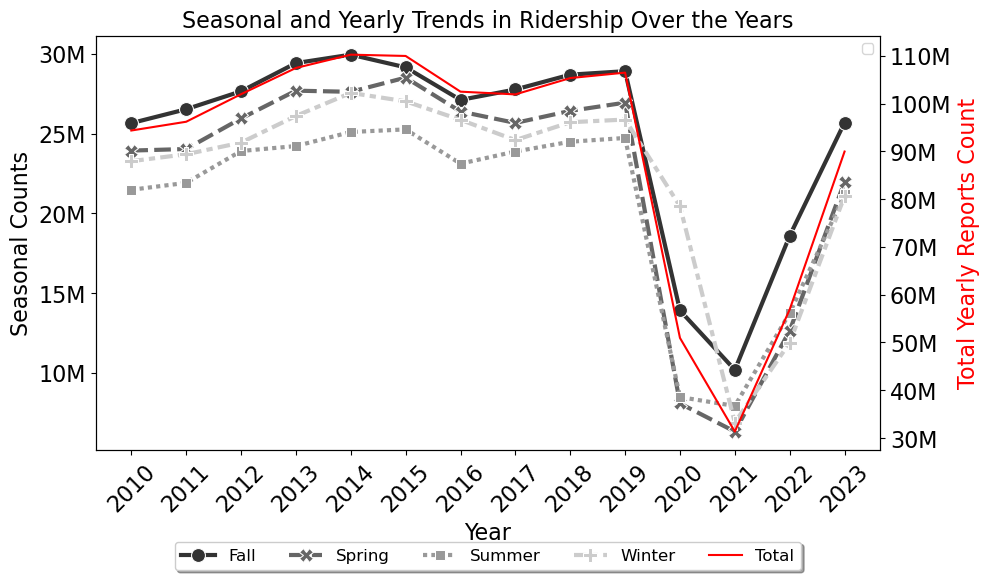

In [37]:
# Select numeric columns for summation
numeric_columns = ['adult_book_of_tickets_ridership',
       'adult_cash_single_ticket_ride_ridership',
       'adult_monthly_pass_ridership', 'adult_ridership',
       'boarding_passengers', 'bus_boarding_passengers',
       'ctrain_boarding_passengers', 'free_fare_zone_ridership', 'ridership',
       'seniors_pass_ridership', 'u_pass_ridership',
       'youth_cash_single_ticket_ride_ridership',
       'youth_monthly_pass_ridership', 'youth_ridership',]

# Seasonal Trends Analysis
data = df.drop(columns=['month', 'year'], axis=1)
data['date'] = pd.to_datetime(df['date'], format='%Y/%m')
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
seasonal_trends = other_funcs.get_seasons(data)

# Yearly Trends Analysis
yearly_trends = seasonal_trends.groupby('year')[numeric_columns].sum().reset_index()

# Ticket Type Popularity
ticket_types = ['adult_book_of_tickets_ridership', 'adult_cash_single_ticket_ride_ridership', 
                'adult_monthly_pass_ridership', 'seniors_pass_ridership', 'u_pass_ridership', 
                'youth_cash_single_ticket_ride_ridership', 'youth_monthly_pass_ridership']

ticket_popularity = seasonal_trends[ticket_types].sum().sort_values(ascending=True)


plot_seasonal_and_total_trends(seasonal_trends, yearly_trends,  'Seasonal and Yearly Trends in Ridership Over the Years', save_png=True, population='all', **defaults_seasonal)


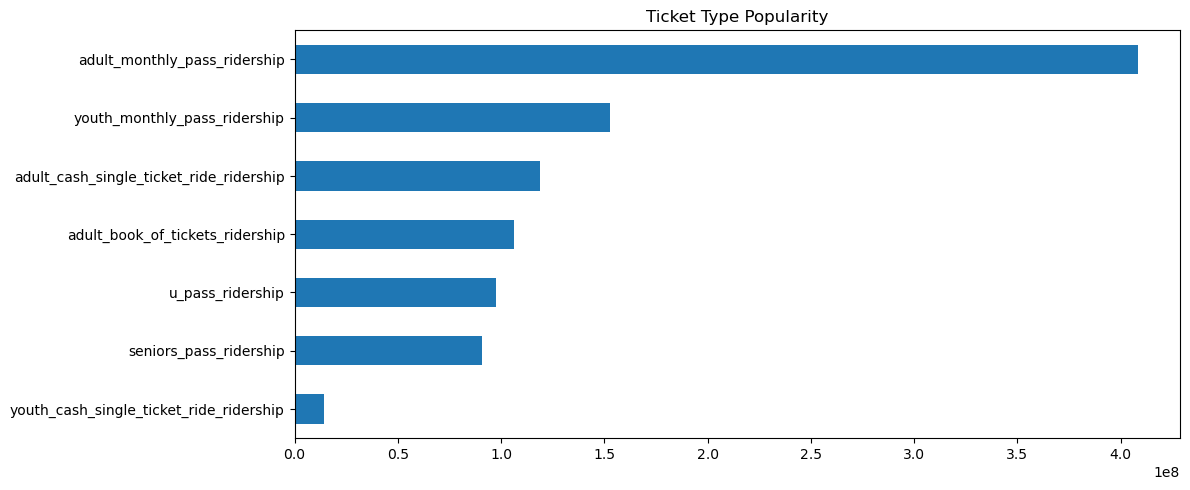

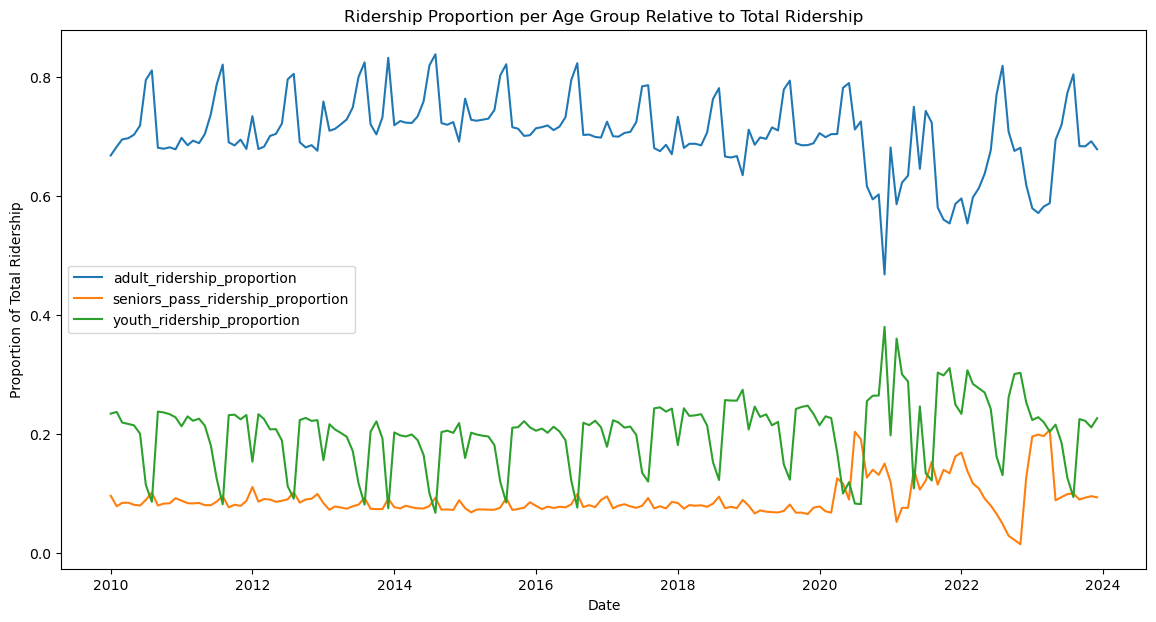

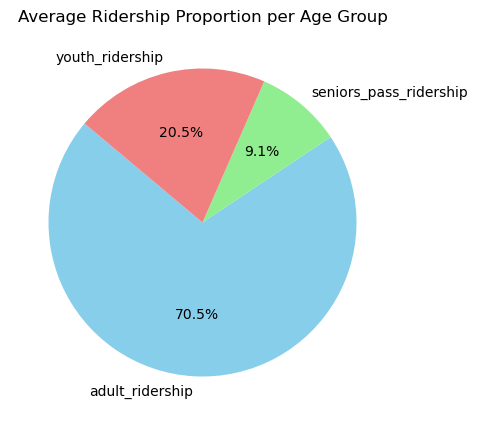

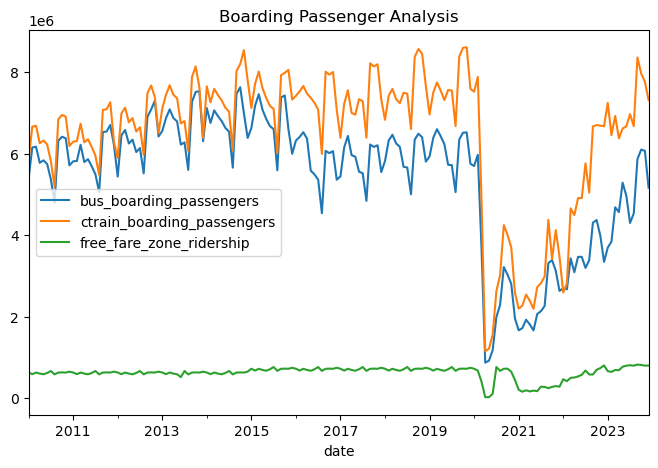

In [38]:


plt.figure(figsize=(12,5))
ticket_popularity.plot(kind='barh',)
plt.title('Ticket Type Popularity')
plt.tight_layout()
plt.savefig('../reports/figures/ticket_popularity.png', dpi=100)
plt.show()

age_groups = ['adult_ridership','seniors_pass_ridership',  'youth_ridership',]
# calculate the sum of all age groups
data['ridership_all_age_groups'] = data[age_groups].sum(axis=1)

# plot ridership per age group relative to 'ridership' as the total
for group in age_groups:
    data[f'{group}_proportion'] = data[group] / data['ridership_all_age_groups']

# Plotting the proportions over time
plt.figure(figsize=(14, 7))
for group in age_groups:
    plt.plot(data['date'], data[f'{group}_proportion'], label=f'{group}_proportion')

plt.title('Ridership Proportion per Age Group Relative to Total Ridership')
plt.xlabel('Date')
plt.ylabel('Proportion of Total Ridership')
plt.legend()
# plt.savefig('../reports/figures/ridership_agegroups.png')
plt.show()

# Calculate the average proportion of each age group over the entire dataset
average_proportions = data[[f'{group}_proportion' for group in age_groups]].mean()

# Plotting the average proportions in a pie chart
plt.figure(figsize=(7,5))
plt.pie(average_proportions, labels=age_groups, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Average Ridership Proportion per Age Group')
plt.savefig('../reports/figures/ridership_agegroups.png')
plt.show()

# Boarding Passenger Analysis
boarding_analysis = data[['date', 'bus_boarding_passengers', 'ctrain_boarding_passengers', 'free_fare_zone_ridership']].set_index('date')
boarding_analysis.plot(figsize=(8, 5))
plt.title('Boarding Passenger Analysis')
plt.show()


# Make maps
I haven't worked with map data yet, so let's ask GPT4 to help with that. After a few prompting iterations, the desired code was generated. Not perfect but good enough for a first impression of the data.

In [39]:
## Plot rountes on the map per route short name
# Load the CSV file
file_path = '../data/raw/Calgary_Transit_Routes_20240624.csv'
df = pd.read_csv(file_path)

# Create a map centered around Calgary
m = folium.Map(location=[51.0447, -114.0719], zoom_start=11)

# Define the number of routes (152 in your case)
num_routes = len(df['ROUTE_SHORT_NAME'].unique())

# Generate the husl color palette
color_palette = sns.color_palette("tab10", num_routes, desat=0.9) #Set3

# Convert the palette to hex codes for easier use
color_map = [rgb2hex(color) for color in color_palette]

# Function to handle MultiLineString and LineString
def add_routes(row):
    try:
        geom = wkt.loads(row['MULTILINESTRING'])
        route_short_name = row['ROUTE_SHORT_NAME']
        route_category = row['ROUTE_CATEGORY']
        
        if geom.geom_type == 'MultiLineString':
            for line in geom.geoms:  # Iterate over each LineString in MultiLineString
                coords = line.coords  # Get coordinates of the LineString
                coord_list = [(coord[1], coord[0]) for coord in coords]  # Extract (lat, lon) tuples
                color = color_map[df[df['ROUTE_SHORT_NAME'] == route_short_name].index[0]]
                folium.PolyLine(coord_list, color=color, weight=2.5, opacity=1).add_to(m)
        elif geom.geom_type == 'LineString':
            coords = geom.coords  # Get coordinates of the LineString
            coord_list = [(coord[1], coord[0]) for coord in coords]  # Extract (lat, lon) tuples
            color = color_map[df[df['ROUTE_SHORT_NAME'] == route_short_name].index[0]]
            folium.PolyLine(coord_list, color=color, weight=2.5, opacity=1).add_to(m)
        else:
            print(f"Unknown geometry type: {geom.geom_type}")
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")

# Apply the function to each row in the dataframe
df.apply(add_routes, axis=1)

# Save the map to an HTML file
m.save('calgary_transit_routes_map_with_legend.html')


In [40]:
## Plot rountes on the map per route category as distriguishing between 153 colors is rather difficult.
## However, since most routes are of the same category, this view is less informative.
## Unfortunately, I can't get the legend to work. Will need to come back to this if the maps turn out to be useful.

# Load the CSV file
file_path = '../data/raw/Calgary_Transit_Routes_20240624.csv'
df = pd.read_csv(file_path)

# Create a map centered around Calgary
m = folium.Map(location=[51.0447, -114.0719], zoom_start=11)

# Define your colormap and categories
categories = df['ROUTE_CATEGORY'].unique()
num_categories = len(categories)
color_map = plt.cm.get_cmap('tab10', num_categories)  # Choose a colormap and number of categories

# Function to handle MultiLineString and LineString
def add_routes(row):
    try:
        geom = wkt.loads(row['MULTILINESTRING'])
        route_category = row['ROUTE_CATEGORY']
        
        if geom.geom_type == 'MultiLineString':
            for line in geom.geoms:  # Iterate over each LineString in MultiLineString
                coords = line.coords  # Get coordinates of the LineString
                coord_list = [(coord[1], coord[0]) for coord in coords]  # Extract (lat, lon) tuples
                color = rgb2hex(color_map(categories.tolist().index(route_category)))
                folium.PolyLine(coord_list, color=color, weight=2.5, opacity=1).add_to(m)
        elif geom.geom_type == 'LineString':
            coords = geom.coords  # Get coordinates of the LineString
            coord_list = [(coord[1], coord[0]) for coord in coords]  # Extract (lat, lon) tuples
            color = rgb2hex(color_map(categories.tolist().index(route_category)))
            folium.PolyLine(coord_list, color=color, weight=2.5, opacity=1).add_to(m)
        else:
            print(f"Unknown geometry type: {geom.geom_type}")
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")

# Apply the function to each row in the dataframe
df.apply(add_routes, axis=1)

# Save the map to an HTML file
m.save('calgary_transit_routes_map_by_category.html')


C:\Users\gotat\AppData\Local\Temp\ipykernel_28096\2202738279.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', num_categories)  # Choose a colormap and number of categories
